In [137]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [138]:
CONST = 4140e12 # s Hz^2 / (pc / cm^3)

def DM_delay(DM, freq):
    """
    Computes the frequency-dependent dispersion measure
    time delay.
    Inputs:
        - DM [pc*cm^-3]: dispersion measure
        - freq [Hz]: frequency
    Returns:
        - Pulse time delay in [s] 
    """
    return np.float32(DM * CONST) / freq**2

def make_frb(ntimes=4096, nfreqs=2048, f_min=1150e6, f_max=1650e6, DM=332.72, pulse_width=2.12e-3, pulse_amp=2, t0=2e-3,
             dtype='float32', cdtype='complex64'):
    """
    Simulates a fast radio burst (FRB) observation given a 
    certain set of parameters.
    Inputs:
        - ntimes (int): number of integration times
        - freqs (int): number of spectral frequency channels
        - f_min (float)|[Hz]: minimum frequency of band
        - f_max (float)|[Hz]: maximum frequency of band
        - DM [pc*cm^-3]: dispersion measure
        - pulse_width [s]: width of FRB pulse
        - pulse_amp: amplitude of FRB pulse
        - t0 [s]: offset the pulse start time
    Returns:
        - Power matrix of shape (ntimes, nfreqs)
    """
    times = np.linspace(0, 1, ntimes) # 1 second interval
    freqs = np.linspace(f_min, f_max, nfreqs)
    dt = times[1] - times[0]
    tmid = times[times.size // 2]
    delays = DM_delay(DM, freqs)
    delays -= tmid + delays[-1] - t0  # center lowest delay at t0

    # assume same inherent profile for all freqs
    pulse = pulse_amp * np.exp(-(times - tmid)**2 / (2 * pulse_width**2))
    _pulse = np.fft.rfft(pulse).astype(cdtype)
    _ffreq = np.fft.rfftfreq(pulse.size, dt)
    phs = np.exp(-2j * np.pi * np.outer(_ffreq.astype(dtype), delays.astype(dtype)))
    _pulse_dly = np.einsum('i,ij->ij', _pulse, phs)
    profile = np.fft.irfft(_pulse_dly, axis=0).astype(dtype)
    profile += np.random.normal(size=profile.shape, loc=10) # add noise
    profile[:,::137] = 0  # blank out rfi
    profile[:,300:500] = 0  # blank out rfi
#     profile[::519] = 100  # rfi
    profile -= np.mean(profile, axis=0, keepdims=True)
    return profile


In [139]:
frb = make_frb(DM=118.62, t0=50*(2e-3))
frb.shape

(4096, 2048)

<IPython.core.display.Javascript object>


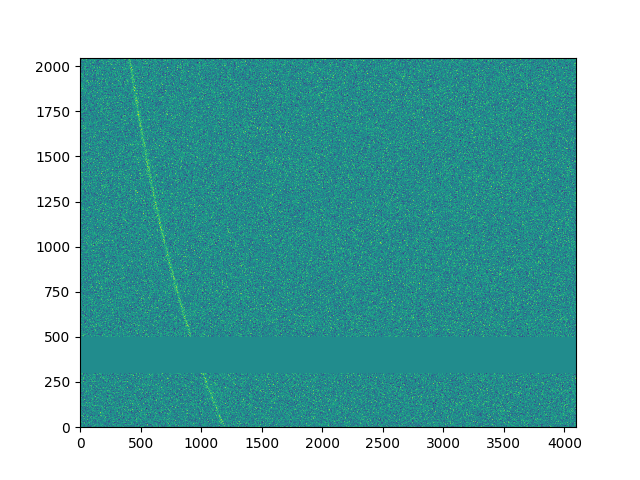

In [140]:
plt.figure()
plt.imshow(frb.T, aspect='auto', interpolation='nearest', origin='lower')
plt.show()

In [141]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [142]:
%%cython
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def phs_sum(np.ndarray [np.complex64_t, ndim=2] d,
            np.ndarray [np.complex64_t, ndim=2] p):
    cdef int i, j
    cdef float complex buf1, buf2
    for i in range(d.shape[0]):
        for j in range(0, d.shape[1], 2):
            buf1 = d[i, j] + d[i, j + 1]
            buf2 = p[i, j] * d[i, j] + p[i, j + 1] * d[i, j + 1]
            d[i, j] = buf1
            d[i, j + 1] = buf2
    return

In [143]:
class FDMT:
    def __init__(self, ntimes, nfreqs, fmin=1150e6, fmax=1650e6, maxDM=500, dtype='float32', cdtype='complex64'):
        self.cache = {}
        self.maxDM = maxDM
        self.dtype = dtype
        self.cdtype = cdtype
#         self.nfreqs = freqs.size
#         self.ntimes = times.size
        self.nfreqs = nfreqs
        self.ntimes = ntimes
        times = np.linspace(0, 1, self.ntimes)
        freqs = np.linspace(fmin, fmax, self.nfreqs)
        _ffreq = np.fft.rfftfreq(self.ntimes, times[1] - times[0]).astype(dtype)
        self.stages = int(np.log2(self.nfreqs))
        chans = np.arange(self.nfreqs, dtype='uint32')
        freqs = freqs.astype(dtype)
        for i in range(1, self.stages):
            delays = DM_delay(maxDM / 2**i, freqs) - DM_delay(maxDM / 2**i, freqs[-1])
            phs = np.exp(2j * np.pi * np.outer(_ffreq, delays))
            freqs = (freqs[0::2] + freqs[1::2]) / 2
            self.cache[i] = phs.astype(cdtype)
            
    def phs_sum(self, d, phs):
        phs_sum(d, phs)
        return [d[:,0::2], d[:,1::2]]
            
    def apply(self, profile):
        self._data = np.fft.rfft(profile, axis=0).astype(self.cdtype)
        ans = [self._data]
        for i in range(1, self.stages):
            ans = sum([self.phs_sum(d, self.cache[i]) for d in ans], [])
        return np.concatenate([np.fft.irfft(d, axis=0) for d in ans], axis=1)

In [144]:
fdmt = FDMT(*frb.shape, maxDM=500)

In [145]:
dmt = fdmt.apply(frb)
dmt.shape

(4096, 2048)

<IPython.core.display.Javascript object>


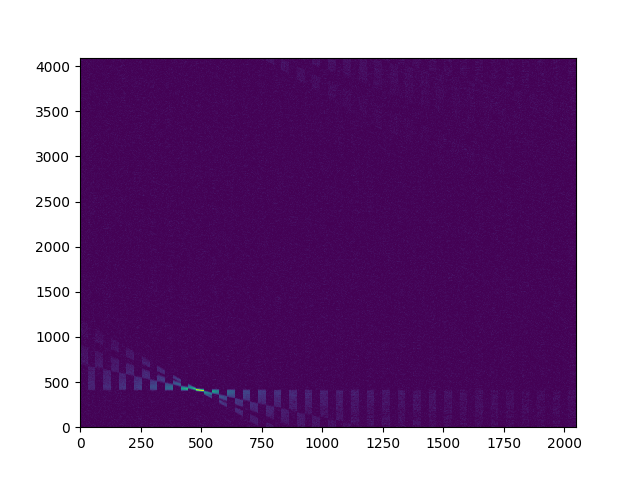

In [146]:
plt.figure()
plt.imshow(np.abs(dmt), aspect='auto', origin='lower', interpolation='nearest')
plt.show()

In [147]:
t0, dm0 = inds = np.unravel_index(np.argmax(dmt, axis=None), dmt.shape)
print(times[t0], np.linspace(0, fdmt.maxDM, frb.shape[1])[dm0])

0.10085470085470086 118.95456765999023
